In [6]:
!nvidia-smi

Fri Nov 10 04:41:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# from google.colab import files
# files.upload()

In [8]:
# import os

# # Set Kaggle API credentials as environment variables
# os.environ['KAGGLE_USERNAME'] = 'kmutnb'
# os.environ['KAGGLE_KEY'] = '2e8f3eec48ac90959791a330f9109431'

# import kaggle

# # Authenticate with Kaggle API
# kaggle.api.authenticate()

In [9]:
# !kaggle datasets download -d dansbecker/cityscapes-image-pairs

In [10]:
# !unzip  /content/cityscapes-image-pairs.zip

In [11]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from torch.optim import lr_scheduler

from tqdm.notebook import tqdm

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [13]:
data_dir = "/content/cityscapes_data/"


# Now you can use 'data_dir' in your code
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

/content/cityscapes_data/train/653.jpg


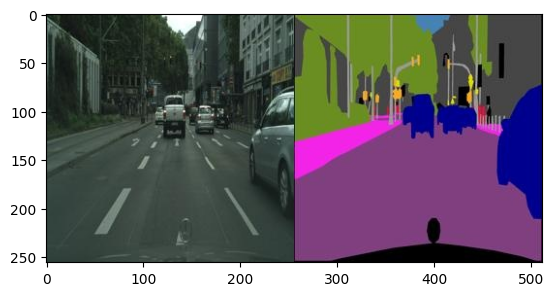

In [14]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [15]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label


(256, 512, 3)
1 255 0 255


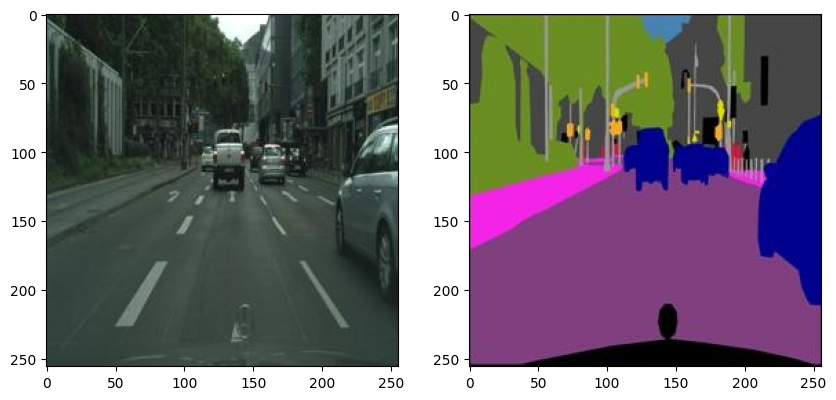

In [16]:
sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

In [17]:
"""
color_set = set()
for train_fn in tqdm(train_fns[:10]):
    train_fp = os.path.join(train_dir, train_fn)
    image = np.array(Image.open(train_fp))
    cityscape, label = split_image(sample_image)
    label = label.reshape(-1, 3)
    local_color_set = set([tuple(c) for c in list(label)])
    color_set.update(local_color_set)
color_array = np.array(list(color_set))
"""

num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[165  19   4]
 [ 35 206 168]
 [ 30 251  15]
 [225 152  29]
 [136  64  93]]


In [18]:
num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

In [19]:
label_model.predict(color_array[:5, :])

array([0, 6, 2, 7, 0], dtype=int32)

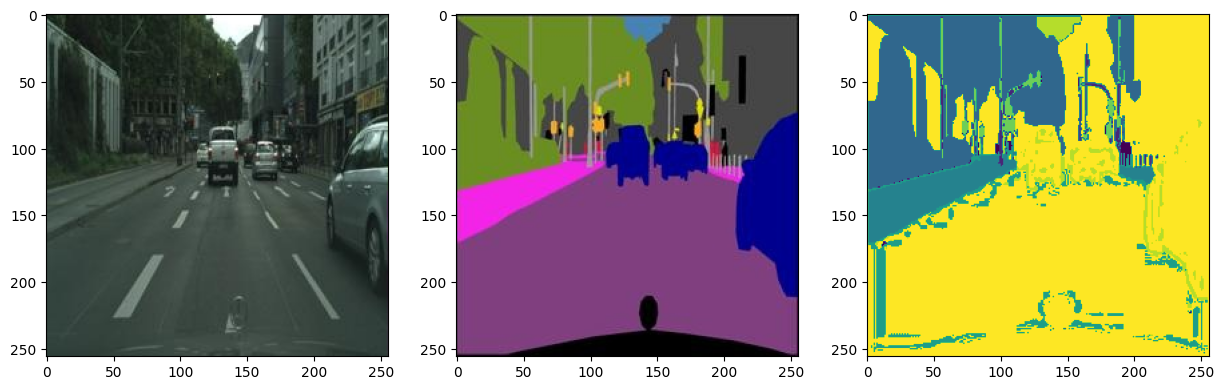

In [20]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [21]:
label_class

array([[9, 9, 9, ..., 9, 9, 9],
       [9, 3, 3, ..., 9, 9, 9],
       [9, 3, 3, ..., 9, 9, 9],
       ...,
       [9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9]], dtype=int32)

In [22]:
class CityscapeDataset(Dataset):

    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model

    def __len__(self):
        return len(self.image_fns)

    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class

    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label

    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [23]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [24]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


In [25]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [26]:
model = UNet(num_classes=num_classes)

In [27]:
# import os
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans

# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms

In [28]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

for X, Y in data_loader:
    # Your code to process each batch goes here
    print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
t

In [29]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([3, 10, 256, 256])


In [30]:
batch_size = 16

epochs = 10
lr = 0.01

In [31]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [32]:
model = UNet(num_classes=num_classes).to(device)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

 10%|█         | 1/10 [04:50<43:31, 290.12s/it]

Epoch 1/10:
Train Loss: 0.9602, Train Accuracy: 4774509.51%



 20%|██        | 2/10 [09:39<38:38, 289.78s/it]

Epoch 2/10:
Train Loss: 0.6564, Train Accuracy: 5202132.71%



 30%|███       | 3/10 [14:28<33:46, 289.52s/it]

Epoch 3/10:
Train Loss: 0.5787, Train Accuracy: 5329590.39%



 40%|████      | 4/10 [19:19<28:58, 289.82s/it]

Epoch 4/10:
Train Loss: 0.5340, Train Accuracy: 5406619.36%



 50%|█████     | 5/10 [24:08<24:09, 289.83s/it]

Epoch 5/10:
Train Loss: 0.5022, Train Accuracy: 5465060.47%



 60%|██████    | 6/10 [28:59<19:20, 290.08s/it]

Epoch 6/10:
Train Loss: 0.4762, Train Accuracy: 5512685.78%



 70%|███████   | 7/10 [33:48<14:29, 289.69s/it]

Epoch 7/10:
Train Loss: 0.4530, Train Accuracy: 5556494.89%



 80%|████████  | 8/10 [38:39<09:40, 290.28s/it]

Epoch 8/10:
Train Loss: 0.4347, Train Accuracy: 5592890.55%



 90%|█████████ | 9/10 [43:31<04:50, 290.58s/it]

Epoch 9/10:
Train Loss: 0.4195, Train Accuracy: 5621344.03%



100%|██████████| 10/10 [48:23<00:00, 290.31s/it]


Epoch 10/10:
Train Loss: 0.4041, Train Accuracy: 5653398.89%


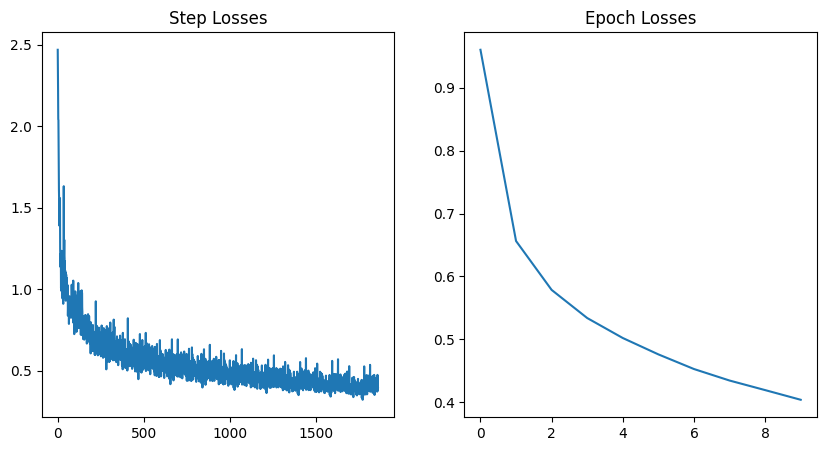

In [34]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Lists to store losses and accuracies
step_losses = []
epoch_losses = []
train_losses = []
train_accuracies = []

for epoch in tqdm(range(epochs)):
    # Training loop
    model.train()
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        step_losses.append(loss.item())

        _, predicted = torch.max(Y_pred.data, 1)
        total_train += Y.size(0)
        correct_train += (predicted == Y).sum().item()

    epoch_losses.append(epoch_loss/len(data_loader))
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Update the learning rate scheduler
    scheduler.step()

    # Print and/or log the metrics for each epoch
    print(f"Epoch {epoch + 1}/{epochs}:")
    print(f"Train Loss: {epoch_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%")

# Plot step and epoch losses
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[0].set_title("Step Losses")
axes[1].plot(epoch_losses)
axes[1].set_title("Epoch Losses")

# Save the model
model_name = "U-Net-SDG.pth"
torch.save(model.state_dict(), model_name)

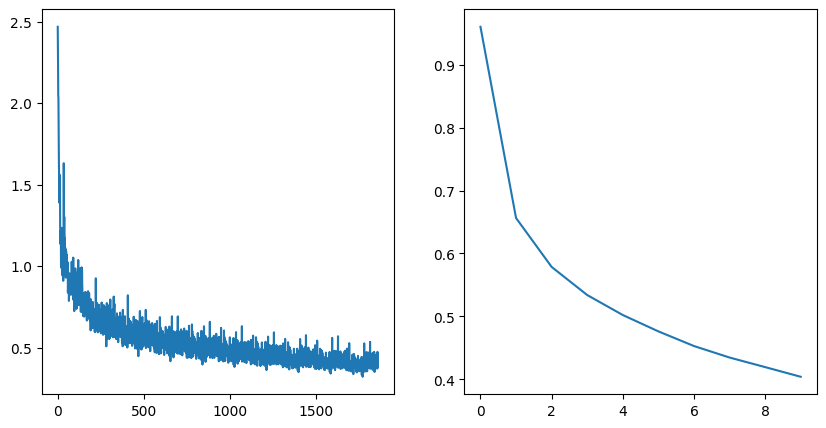

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [36]:
model_path = model_name
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [37]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [38]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


In [39]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

In [40]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")


Output hidden; open in https://colab.research.google.com to view.

In [49]:
model.eval()
predictions = []

with torch.no_grad():
    for X_val, Y_val in data_loader:
        X_val, Y_val = X_val.to(device), Y_val.to(device)
        Y_pred_val = model(X_val)
        predictions.append(Y_pred_val.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)


In [59]:
threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.uint8)
flat_predictions = binary_predictions.reshape(-1, num_classes)


In [60]:
ground_truth_labels = np.concatenate([Y_val.cpu().numpy().reshape(-1, 1) for X_val, Y_val in data_loader], axis=0)


In [61]:
from sklearn.metrics import average_precision_score

mAP_per_class = []
for class_index in range(num_classes):
    y_true = (ground_truth_labels == class_index).astype(np.uint8)
    y_score = flat_predictions[:, class_index]
    mAP_class = average_precision_score(y_true, y_score)
    mAP_per_class.append(mAP_class)

mAP = np.mean(mAP_per_class)
print(f'mAP: {mAP:.4f}')

mAP: 0.1007
